In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from mlxtend.evaluate import bias_variance_decomp

In [2]:
bids_df= pd.read_csv('data/bids.csv')
train_df = pd.read_csv('data/train.csv')
test_df= pd.read_csv('data/test.csv')

In [3]:
bids_unique= bids_df.groupby('bidder_id').nunique()
bids_unique = bids_unique.drop(["bid_id"],axis = 1)

In [4]:
train_set = train_df.merge(bids_unique, how= 'left', on = 'bidder_id')
test_set = test_df.merge(bids_unique, how= 'left', on = 'bidder_id')

In [5]:
print("TRAIN SET")
print(train_set.isnull().sum())
print("-" * 100)
print("TEST SET")
print(test_set.isnull().sum())

TRAIN SET
bidder_id           0
payment_account     0
address             0
outcome             0
auction            29
merchandise        29
device             29
time               29
country            29
ip                 29
url                29
dtype: int64
----------------------------------------------------------------------------------------------------
TEST SET
bidder_id           0
payment_account     0
address             0
auction            70
merchandise        70
device             70
time               70
country            70
ip                 70
url                70
dtype: int64


In [6]:
train_set.fillna(0,inplace = True)
test_set.fillna(0,inplace = True)

In [7]:
print("TRAIN SET")
print(train_set.isnull().sum())
print("-" * 100)
print("TEST SET")
print(test_set.isnull().sum())

TRAIN SET
bidder_id          0
payment_account    0
address            0
outcome            0
auction            0
merchandise        0
device             0
time               0
country            0
ip                 0
url                0
dtype: int64
----------------------------------------------------------------------------------------------------
TEST SET
bidder_id          0
payment_account    0
address            0
auction            0
merchandise        0
device             0
time               0
country            0
ip                 0
url                0
dtype: int64


In [8]:
X = train_set.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome']) 
y = train_set['outcome']
X_test_original = test_set.drop(columns=['bidder_id', 'payment_account', 'address'])

Text(0.5, 1.0, 'Distribution of Human to Bot Bidders')

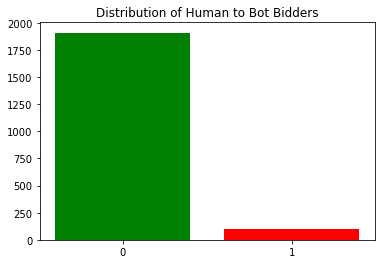

In [29]:
distribution = y.value_counts()
plt.bar(["0", "1"], distribution, color=['green','red'])
plt.title("Distribution of Human to Bot Bidders")

In [9]:
def evaluate(model, X_train, y_train, X_test, y_test):
    print("TRAIN")
    train_predictions = model.predict_proba(X_train)
    train_pred = model.predict(X_train)
        
    train_accuracy = accuracy_score(y_train, train_pred)
    train_auc_roc_score = roc_auc_score(y_train,train_predictions[:,1])
    train_fbeta = fbeta_score(y_train, train_pred, average='binary', beta=2.0)
    
    print("Classification report")
    print(classification_report(y_train, train_pred, digits = 4))
    
    print("FBeta Score")
    print(fbeta_score(y_train, train_pred, average='binary', beta=2.0))
    
    print('Model Performance')
    print('Accuracy = {:0.4f}%.'.format(train_accuracy))
    print('AUC ROC = {:0.4f}%.'.format(train_auc_roc_score))
    print("*" * 100)
    
    print("TEST")
    
    test_predictions = model.predict_proba(X_test)
    test_pred = model.predict(X_test)
        
    test_accuracy = accuracy_score(y_test, test_pred)
    test_auc_roc_score = roc_auc_score(y_test,test_predictions[:,1])
    test_fbeta = fbeta_score(y_test, test_pred, average='binary', beta=2.0)
    
    print("Classification report")
    print(classification_report(y_test, test_pred, digits = 4))
    
    print("FBeta Score")
    print(fbeta_score(y_test, test_pred, average='binary', beta=2.0))
    
    print('Model Performance')
    print('Accuracy = {:0.4f}%.'.format(test_accuracy))
    print('AUC ROC = {:0.4f}%.'.format(test_auc_roc_score))
    print("*" * 100)
    
    return [train_accuracy, train_auc_roc_score, train_fbeta, test_accuracy, test_auc_roc_score, test_fbeta]

def process_results(arr):
    train_accuracy = []
    train_auc_roc_score = [] 
    train_fbeta = []
    test_accuracy = []
    test_auc_roc_score = []
    test_fbeta = []
    
    for item in arr:
        train_accuracy.append(item[0])
        train_auc_roc_score.append(item[1])
        train_fbeta.append(item[2])
        test_accuracy.append(item[3])
        test_auc_roc_score.append(item[4])
        test_fbeta.append(item[5])
    
    mean_accuracy = np.array(train_accuracy).mean()
    mean_train_auc_roc_score = np.array(train_auc_roc_score).mean()
    mean_train_fbeta = np.array(train_fbeta).mean()
    mean_test_accuracy = np.array(test_accuracy).mean()
    mean_test_auc_roc_score = np.array(test_auc_roc_score).mean()
    mean_test_fbeta = np.array(test_fbeta).mean()
    
    print("final train accuracy: " + str(mean_accuracy))
    print("final train AUC: " + str(mean_train_auc_roc_score))
    print("final train fbeta: " + str(mean_train_fbeta))
    print("final test accuracy: " + str(mean_test_accuracy))
    print("final test AUC: " + str(mean_test_auc_roc_score))
    print("final test fbeta: " + str(mean_test_fbeta))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
def create_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
ann = KerasClassifier(build_fn=create_model, verbose=0)

In [12]:
dt.fit(X_train, y_train)
evaluate(dt, X_train, y_train, X_test, y_test)

TRAIN
Classification report
              precision    recall  f1-score   support

         0.0     0.9970    1.0000    0.9985      1333
         1.0     1.0000    0.9474    0.9730        76

    accuracy                         0.9972      1409
   macro avg     0.9985    0.9737    0.9857      1409
weighted avg     0.9972    0.9972    0.9971      1409

FBeta Score
0.9574468085106381
Model Performance
Accuracy = 0.9972%.
AUC ROC = 0.9961%.
****************************************************************************************************
TEST
Classification report
              precision    recall  f1-score   support

         0.0     0.9686    0.9636    0.9661       577
         1.0     0.3000    0.3333    0.3158        27

    accuracy                         0.9354       604
   macro avg     0.6343    0.6485    0.6410       604
weighted avg     0.9388    0.9354    0.9370       604

FBeta Score
0.32608695652173914
Model Performance
Accuracy = 0.9354%.
AUC ROC = 0.6109%.
*************

[0.9971611071682044,
 0.99605164449007,
 0.9574468085106381,
 0.9354304635761589,
 0.6108543552217728,
 0.32608695652173914]

In [13]:
rf.fit(X_train, y_train)
evaluate(rf, X_train, y_train, X_test, y_test)

TRAIN
Classification report
              precision    recall  f1-score   support

         0.0     0.9970    1.0000    0.9985      1333
         1.0     1.0000    0.9474    0.9730        76

    accuracy                         0.9972      1409
   macro avg     0.9985    0.9737    0.9857      1409
weighted avg     0.9972    0.9972    0.9971      1409

FBeta Score
0.9574468085106381
Model Performance
Accuracy = 0.9972%.
AUC ROC = 0.9854%.
****************************************************************************************************
TEST
Classification report
              precision    recall  f1-score   support

         0.0     0.9631    0.9965    0.9796       577
         1.0     0.7143    0.1852    0.2941        27

    accuracy                         0.9603       604
   macro avg     0.8387    0.5909    0.6368       604
weighted avg     0.9520    0.9603    0.9489       604

FBeta Score
0.21739130434782608
Model Performance
Accuracy = 0.9603%.
AUC ROC = 0.8841%.
*************

[0.9971611071682044,
 0.9854305681683578,
 0.9574468085106381,
 0.9602649006622517,
 0.8840747159637974,
 0.21739130434782608]

In [14]:
xgb.fit(X_train, y_train)
evaluate(xgb, X_train, y_train, X_test, y_test)

[15:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



TRAIN
Classification report
              precision    recall  f1-score   support

         0.0     0.9970    1.0000    0.9985      1333
         1.0     1.0000    0.9474    0.9730        76

    accuracy                         0.9972      1409
   macro avg     0.9985    0.9737    0.9857      1409
weighted avg     0.9972    0.9972    0.9971      1409

FBeta Score
0.9574468085106381
Model Performance
Accuracy = 0.9972%.
AUC ROC = 0.9909%.
****************************************************************************************************
TEST
Classification report
              precision    recall  f1-score   support

         0.0     0.9711    0.9896    0.9803       577
         1.0     0.6250    0.3704    0.4651        27

    accuracy                         0.9619       604
   macro avg     0.7980    0.6800    0.7227       604
weighted avg     0.9556    0.9619    0.9572       604

FBeta Score
0.40322580645161293
Model Performance
Accuracy = 0.9619%.
AUC ROC = 0.8507%.
************

[0.9971611071682044,
 0.9908792987720615,
 0.9574468085106381,
 0.9619205298013245,
 0.85069645034983,
 0.40322580645161293]

In [15]:
ann.fit(X_train, y_train)
evaluate(ann, X_train, y_train, X_test, y_test)

TRAIN
Classification report

C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.pred


              precision    recall  f1-score   support

         0.0     0.9498    0.9370    0.9434      1333
         1.0     0.1064    0.1316    0.1176        76

    accuracy                         0.8935      1409
   macro avg     0.5281    0.5343    0.5305      1409
weighted avg     0.9043    0.8935    0.8988      1409

FBeta Score
0.12562814070351758
Model Performance
Accuracy = 0.8935%.
AUC ROC = 0.2630%.
****************************************************************************************************
TEST
Classification report
              precision    recall  f1-score   support

         0.0     0.9601    0.9185    0.9389       577
         1.0     0.0962    0.1852    0.1266        27

    accuracy                         0.8858       604
   macro avg     0.5281    0.5519    0.5327       604
weighted avg     0.9215    0.8858    0.9026       604

FBeta Score
0.15625
Model Performance
Accuracy = 0.8858%.
AUC ROC = 0.2939%.
***************************************************

C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0.893541518807665,
 0.263024637738382,
 0.12562814070351758,
 0.8857615894039735,
 0.2938571153475833,
 0.15625]

In [16]:
X_train.shape

(1409, 7)

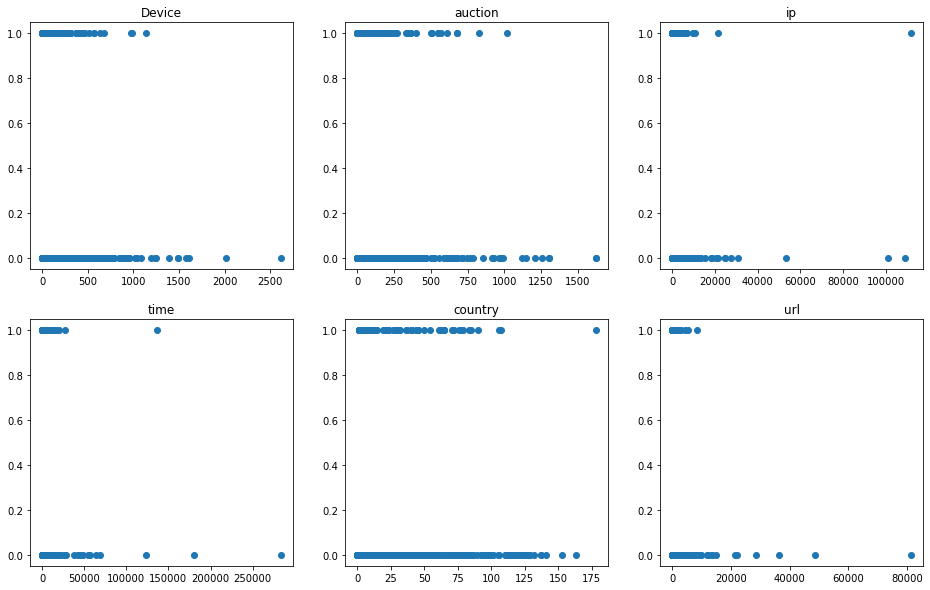

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3, figsize=(16,10))
ax[0,0].scatter(train_set['device'], train_set['outcome'])
ax[0,0].title.set_text('Device')
ax[0,1].scatter(train_set['auction'], train_set['outcome'])
ax[0,1].title.set_text('auction')
ax[1,0].scatter(train_set['time'], train_set['outcome'])
ax[1,0].title.set_text('time')
ax[1,1].scatter(train_set['country'], train_set['outcome'])
ax[1,1].title.set_text('country')
ax[0,2].scatter(train_set['ip'], train_set['outcome'])
ax[0,2].title.set_text('ip')
ax[1,2].scatter(train_set['url'], train_set['outcome'])
ax[1,2].title.set_text('url')